In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from FIESTA_functions import *
from HARPS_N_functions import *
from NEID_solar_functions import *
from functions import *

In [2]:
from multiprocessing import Pool
import time
import math
from scipy import optimize
import scipy.optimize as opt

### Simplified optimisation (example)

CPU times: user 255 ms, sys: 0 ns, total: 255 ms
Wall time: 256 ms
[-0.30103001  0.95424249  1.00000202]


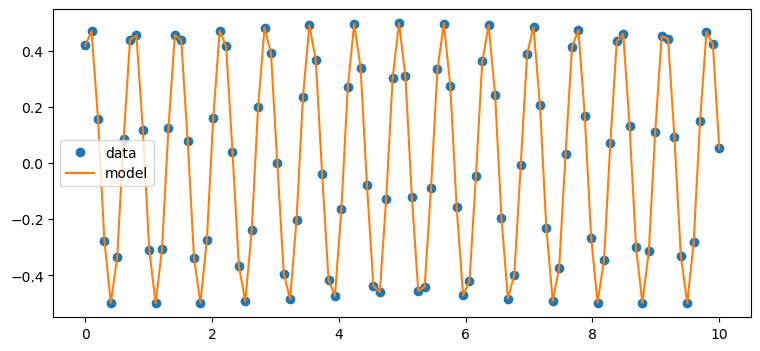

In [3]:
x_data = np.linspace(0,10,100)
y_data = 0.5*np.sin(x_data*9+1)

def model(params):
    y = 10**params[0]*np.sin(10**params[1]*x_data+params[2]) 
    return y

def loss(params):    
    diff = model(params) - y_data
    return np.sum(diff**2)

import scipy.optimize as opt
%time sol = opt.dual_annealing(loss, bounds=[[-1,1] for i in np.arange(2)] + [[0, np.pi]] )
print(sol.x)

fig = plt.figure(figsize=(9, 4))
plt.plot(x_data, y_data, 'o', label='data')
plt.plot(x_data, model(sol.x), label='model')
plt.legend()

# Data

In [4]:
#----------------------------------
# Read data
#----------------------------------
RV_FT_k     = np.loadtxt('../lib/FIESTA_daily_output/RV_FT_k.txt')
eRV_FT_k    = np.loadtxt('../lib/FIESTA_daily_output/eRV_FT_k.txt')
ΔRV_k       = np.loadtxt('../lib/FIESTA_daily_output/ΔRV_k.txt')
bjd_daily   = np.loadtxt('../lib/FIESTA_daily_output/bjd_daily.txt')
rv_daily    = np.loadtxt('../lib/FIESTA_daily_output/rv_daily.txt')
σrv_daily   = np.loadtxt('../lib/FIESTA_daily_output/σrv_daily.txt')

In [5]:
X = ΔRV_k.T
Y = rv_daily - np.mean(rv_daily) 

X.shape, Y.shape

((202, 47), (202,))

In [6]:
k_max = 5
N = 10

# injected parameters 
amp = np.logspace(-1, 1, N)
t_inj = 0.5
phase_inj = 1

t = bjd_daily - min(bjd_daily)
w_array_1 = np.zeros((N, k_max))
amp_pred_1 = np.zeros(N)
rms_array_1 = np.zeros(N)
phase_pred_1 = np.zeros(N)
t_pred_1 = np.zeros(N)

amp_pred_2 = np.zeros(N)
rms_array_2 = np.zeros(N)
phase_pred_2 = np.zeros(N)
t_pred_2 = np.zeros(N)

def wmse(y1, y2, w):
    wmse = np.average((y1-y2)**2, weights = w)
    return wmse

def model_1(params):
    planet_rv_model = 10**params[k_max+1]*np.sin(10**params[k_max+3]*t + params[k_max+2]) 
    stellar_rv_model = np.sum(params[:k_max]*X[:,:k_max], axis=1) + params[k_max]
    rv_model = planet_rv_model + stellar_rv_model
    return rv_model

def model_2(params):
    '''
        Keplerian model
    '''
    planet_rv_model = 10**params[0]*np.sin(10**params[2]*t + params[1]) 
    return planet_rv_model

def execute(i):
    y = Y + amp[i] *np.sin(t_inj*t+phase_inj)  
    
    def loss_1(params):
        return wmse(model_1(params), y, 1/σrv_daily**2)
    
    def loss_2(params):
        return wmse(model_2(params), y, 1/σrv_daily**2)    
    
    sol_1 = opt.dual_annealing(loss_1, bounds=[[-5,5] for i in np.arange(k_max+1)] + [[-1.1,1.1], [0, np.pi], [np.log10(t_inj/1.5), np.log10(t_inj*1.5)]],  maxiter=1000)
    sol_2 = opt.dual_annealing(loss_2, bounds= [[-1.1,1.1], [0, np.pi], [np.log10(t_inj/1.5), np.log10(t_inj*1.5)]],  maxiter=1000)
    
    fitted_params_1 = sol_1.x
    fitted_params_2 = sol_2.x    

    w_array_1[i] = fitted_params_1[:k_max]
    amp_pred_1[i] = 10**fitted_params_1[k_max+1]
    phase_pred_1[i] = fitted_params_1[k_max+2]
    t_pred_1[i] = 10**fitted_params_1[k_max+3]
    rms_array_1[i] = loss_1(fitted_params_1)**0.5

    amp_pred_2[i] = 10**fitted_params_2[0]
    phase_pred_2[i] = fitted_params_2[1]
    t_pred_2[i] = 10**fitted_params_2[2]
    rms_array_2[i] = loss_2(fitted_params_2)**0.5
    
    return w_array_1[i], amp_pred_1[i], phase_pred_1[i], t_pred_1[i] , rms_array_1[i], amp_pred_2[i], phase_pred_2[i], t_pred_2[i], rms_array_2[i]

if __name__ == "__main__":
    # first way, using multiprocessing
    start_time = time.perf_counter()
    
    with Pool(processes=os.cpu_count()) as pool:
        result = pool.map(execute, range(0,N)) 
    
    finish_time = time.perf_counter()
    print("Program finished in {} seconds - using multiprocessing".format(finish_time-start_time))
    print("---")

for i in range(len(result)):
    w_array_1[i], amp_pred_1[i], phase_pred_1[i], t_pred_1[i] , rms_array_1[i], amp_pred_2[i], phase_pred_2[i], t_pred_2[i], rms_array_2[i] = result[i]  = result[i] 
    
print('amp\n', amp)
print('amp_pred\n', amp_pred_1)
print('amp_pred\n', amp_pred_2)

Program finished in 2.873665304854512 seconds - using multiprocessing
---
amp
 [ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]
amp_pred
 [ 0.57982704  0.60058139  0.63600372  0.87834341  1.16663275  1.66028392
  2.50270854  3.92447217  6.31399016 10.32399293]
amp_pred
 [ 0.66679016  0.68706954  0.70021692  0.87033335  1.16382541  1.66500046
  2.51388296  3.94238698  6.3357133  10.3357405 ]


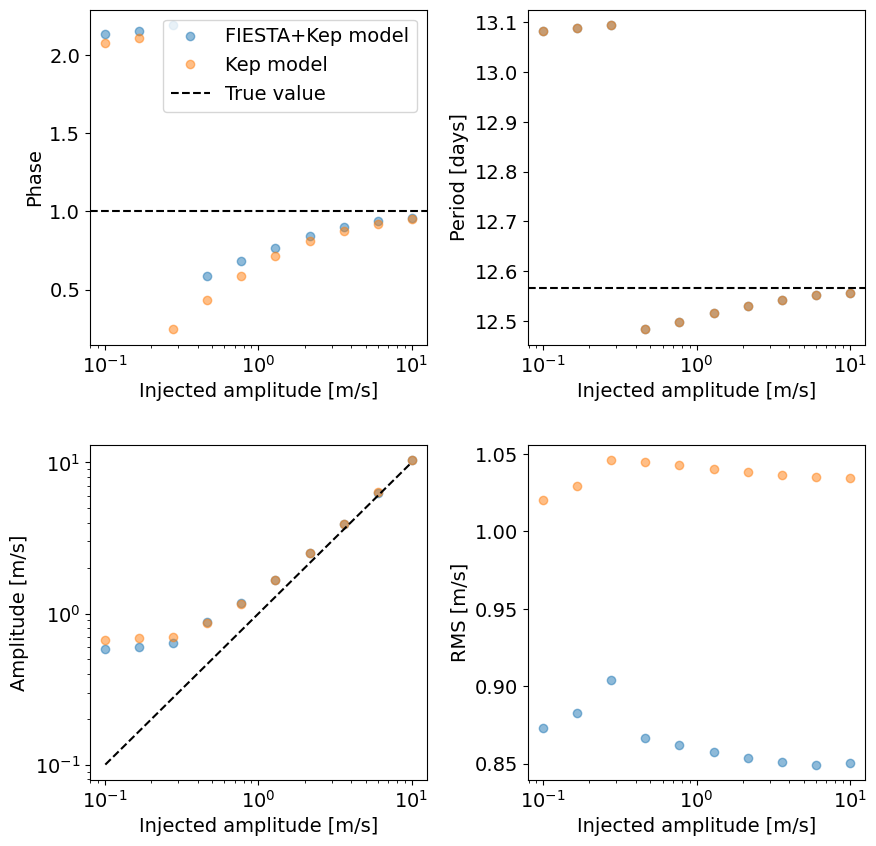

In [7]:
plt.rcParams['font.size'] = '14'

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

axs[0,0].plot(amp, phase_pred_1, 'o', alpha=0.5, label='FIESTA+Kep model')
axs[0,0].plot(amp, phase_pred_2, 'o', alpha=0.5, label='Kep model')
axs[0,0].set_xscale('log')
axs[0,0].axhline(y = phase_inj, color = 'k', linestyle = '--', label='True value')
axs[0,0].set_xlabel('Injected amplitude [m/s]')
axs[0,0].set_ylabel('Phase')
axs[0,0].legend()

axs[0,1].plot(amp, 2*np.pi/t_pred_1, 'o', alpha=0.5)
axs[0,1].plot(amp, 2*np.pi/t_pred_1, 'o', alpha=0.5)
axs[0,1].set_xscale('log')
axs[0,1].axhline(y = 2*np.pi/t_inj, color = 'k', linestyle = '--')
axs[0,1].set_xlabel('Injected amplitude [m/s]')
axs[0,1].set_ylabel('Period [days]')

axs[1,0].plot(amp, amp_pred_1, 'o', alpha=0.5)
axs[1,0].plot(amp, amp_pred_2, 'o', alpha=0.5)
axs[1,0].plot(amp, amp, 'k--')
axs[1,0].set_xlabel('Injected amplitude [m/s]')
axs[1,0].set_ylabel('Amplitude [m/s]')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')


axs[1,1].plot(amp, rms_array_1, 'o', alpha=0.5)
axs[1,1].plot(amp, rms_array_2, 'o', alpha=0.5)
axs[1,1].set_xlabel('Injected amplitude [m/s]')
axs[1,1].set_ylabel('RMS [m/s]')
axs[1,1].set_xscale('log')

plt.show()